In [1]:
import cv2
import numpy as np
from skimage import io
from skimage import data
from skimage import transform
from skimage.filters import gaussian
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage.feature import (match_descriptors, corner_harris, corner_subpix, corner_shi_tomasi, corner_fast,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [2]:
import skimage
import skimage.io
import skimage.segmentation

from skimage import feature
from skimage import color

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

from skimage.morphology import *

import numpy as np

import matplotlib.pyplot as plt

from scipy.ndimage.morphology import distance_transform_edt

import cv2

def otsu_image(image, threshold=0):
    gray = 1 - image
    threshold = threshold_otsu(gray)

    return binary_dilation(gray > threshold)

In [3]:
from skimage.color import rgb2gray
from skimage.io import imread
image = rgb2gray(imread("./labellized/Atlas_de_Jacoubet_11._Hospice_Beaujon_et_ses_environs/01_dewarped.png"))
binary = remove_small_objects(otsu_image(image), 5000)

img = binary_closing(binary, square(10))
img = remove_small_holes(img, 100000)

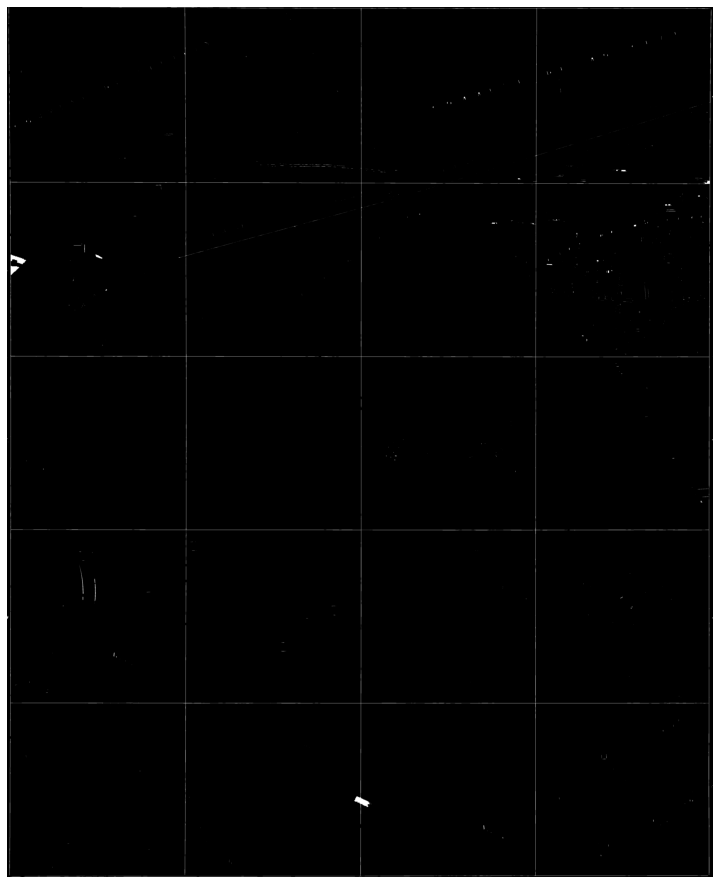

In [4]:
plt.figure(figsize=(16,16))
c = 20
im = (dilation(image, np.array([[1]*c])) < 0.7) | (dilation(image, np.array([[1]]*c)) < 0.7)
im = closing(im, square(10))
plt.axis("off")
plt.imshow(im, cmap=plt.cm.gray)

In [5]:
def find_coords_column(img, nb_colums=5, spacing_threshold=100, line_samples=1000):
    img_part = img[:line_samples,:]
    scores = img_part.sum(axis=0)
    sort_indices = np.argsort(scores)[::-1]

    x_coords = []
    for indice in sort_indices:
        interrupted = False
        for x in x_coords:
            if abs(indice - x) < spacing_threshold:
                interrupted = True
                break
        if not interrupted:
            x_coords.append(indice)
            if len(x_coords) == nb_colums:
                break
    return sorted(x_coords)
            
def find_coords_row(img, nb_colums=5, spacing_threshold=100, line_samples=1000):
    img_part = img[:,:line_samples]
    scores = img_part.sum(axis=1)
    sort_indices = np.argsort(scores)[::-1]

    y_coords = []
    for indice in sort_indices:
        interrupted = False
        for y in y_coords:
            if abs(indice - y) < spacing_threshold:
                interrupted = True
                break
        if not interrupted:
            y_coords.append(indice)
            if len(y_coords) == nb_colums:
                break
    return sorted(y_coords)

def find_columns(img, nb_colummns=5, search_radius=5, threshold=0.01):
    x_coords = find_coords_column(img)
    
    columns_coords = []
    for x in x_coords:
        x_min, x_max = max(x-search_radius, 0), min(x+search_radius, img.shape[1])
        column = img[:,x_min:x_max]
        column_indices = np.argmax(column, axis=1)
        column_coords = []
        for y in range(column.shape[0]):
            column_best_x = column_indices[y]
            if column[y, column_best_x] < threshold:
                continue
            column_coords.append((y, x_min + column_best_x))
        columns_coords.append(column_coords) 
        
    return columns_coords

def find_rows(img, nb_rows=5, search_radius=5, threshold=0.01):
    y_coords = find_coords_row(img)
    
    rows_coords = []
    for y in y_coords:
        y_min, y_max = max(y-search_radius, 0), min(y+search_radius, img.shape[0])
        row = img[y_min:y_max,:]
        row_indices = np.argmax(row, axis=0)
        row_coords = []
        for x in range(row.shape[1]):
            row_best_y = row_indices[x]
            if row[row_best_y, x] < threshold:
                continue
            row_coords.append((y_min + row_best_y, x))
        rows_coords.append(row_coords) 
        
    return rows_coords

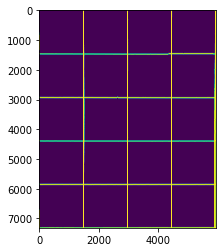

In [6]:
#!pip install bresenham
from bresenham import bresenham

def generate_rows_mask(img, columns, line_width=2):
    mask = np.zeros_like(img)
    for c in columns:
        p0 = c[0]
        column_pixels = []
        for p1 in c:
            if (p1[0] - p0[0]) > 1 or (p1[1] - p0[1]) > 1:
                for pk in bresenham(p0[0], p0[1], p1[0], p1[1]):
                    mask[pk[0]-line_width:pk[0]+line_width, pk[1]] = 1.0
            mask[p1[0]-line_width:p1[0]+line_width, p1[1]] = 1.0
            p0 = p1
    return mask

def generate_columns_mask(img, columns, line_width=2):
    mask = np.zeros_like(img)
    for c in columns:
        p0 = c[0]
        column_pixels = []
        for p1 in c:
            if (p1[0] - p0[0]) > 1 or (p1[1] - p0[1]) > 1:
                for pk in bresenham(p0[0], p0[1], p1[0], p1[1]):
                    mask[pk[0], pk[1]-line_width:pk[1]+line_width] = 1.0
            mask[p1[0], p1[1]-line_width:p1[1]+line_width] = 1.0
            p0 = p1
    return mask

mask_columns = generate_columns_mask(im, find_columns(im, search_radius=10, threshold=0), line_width=20)
mask_rows = generate_rows_mask(im, find_rows(im, search_radius=10, threshold=0), line_width=20)
plt.imshow(mask_rows | mask_columns)